In [2]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean, linregress
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, MultipleLocator
import matplotlib.colors as mcolors
import seaborn as sns

In [3]:
# Import dataframes
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\Regime_check\allorder_TTVFast_fits.csv")
fits.head()

,e1,w1,e2,w2,Delta,mmr,j,N,P1,P2,...,phase1,std1,A2,B2,V2,Pttv2,phase2,std2,R2_1,R2_2
0,0.015016,135.786278,0.015016,315.786278,-0.018080,3:2,3,1,30,44.186407,...,1.966894,0.003061,-0.000834,1.021793e-06,0.006055,812.094692,5.079151,0.004280,0.988654,0.993372
1,0.011390,214.359496,0.011390,214.359496,-0.001431,7:5,7,2,30,41.939893,...,8.997557,0.000518,0.016647,-2.083234e-05,0.063693,19078.532890,6.020330,0.000681,0.000235,0.001789
2,0.001320,41.057194,0.001320,221.057194,-0.012968,5:3,5,2,30,49.351578,...,4.570373,0.000226,-0.000011,7.036167e-09,0.000062,785.713741,7.439063,0.000227,0.013201,0.037107
3,0.015594,22.256611,0.015594,202.256611,0.014695,5:1,5,4,30,152.204196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.020713,348.970550,0.020713,168.970550,0.018677,5:4,5,1,30,38.200388,...,3.640849,0.004922,-0.001175,1.860154e-06,0.005087,388.548663,0.792823,0.005726,0.376617,0.397031


In [4]:
# Compare error relative to solution similar to figure 2 of Deck-Agol
# Code of course copypasted from 1st order TTVfast validation
valid = fits['valid']
j = fits['j']; N = fits['N']
mmr = fits['mmr']
mu_in = fits['mu1']; mu_out = fits['mu2']
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = np.abs(fits['Pttv1']); PTTV_out = np.abs(fits['Pttv2'])
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]
Mstar = 1

# Extract mu_in and mu_out
mu_calc_in, mu_calc_out = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    # if valid[i] == False:  # If invalid column
    #     mu_calc_in = np.append(mu_calc_in, np.nan)
    #     mu_calc_out = np.append(mu_calc_out, np.nan)
    #     continue

    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_code_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i], inner_period=P_in[i])
    mu_code_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i], outer_period=P_out[i])

    mu_calc_in = np.append(mu_calc_in, mu_code_in)
    mu_calc_out = np.append(mu_calc_out, mu_code_out)

compare = fits.copy()
compare['mu_calc_in'] = mu_calc_in
compare['mu_calc_out'] = mu_calc_out
compare.head()

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:59<00:00, 167.16it/s]


,e1,w1,e2,w2,Delta,mmr,j,N,P1,P2,...,A2,B2,V2,Pttv2,phase2,std2,R2_1,R2_2,mu_calc_in,mu_calc_out
0,0.015016,135.786278,0.015016,315.786278,-0.018080,3:2,3,1,30,44.186407,...,-0.000834,1.021793e-06,0.006055,812.094692,5.079151,0.004280,0.988654,0.993372,0.000003,0.000003
1,0.011390,214.359496,0.011390,214.359496,-0.001431,7:5,7,2,30,41.939893,...,0.016647,-2.083234e-05,0.063693,19078.532890,6.020330,0.000681,0.000235,0.001789,0.001967,0.000188
2,0.001320,41.057194,0.001320,221.057194,-0.012968,5:3,5,2,30,49.351578,...,-0.000011,7.036167e-09,0.000062,785.713741,7.439063,0.000227,0.013201,0.037107,0.000010,0.000012
3,0.015594,22.256611,0.015594,202.256611,0.014695,5:1,5,4,30,152.204196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.020713,348.970550,0.020713,168.970550,0.018677,5:4,5,1,30,38.200388,...,-0.001175,1.860154e-06,0.005087,388.548663,0.792823,0.005726,0.376617,0.397031,0.000003,0.000003


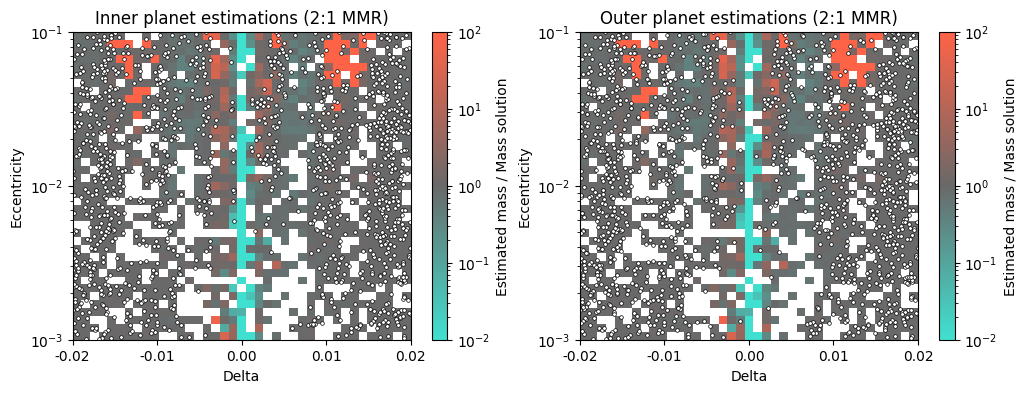

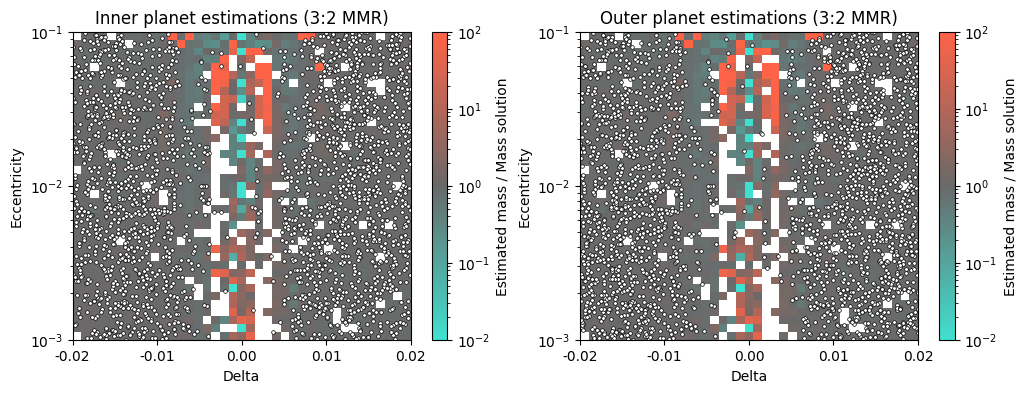

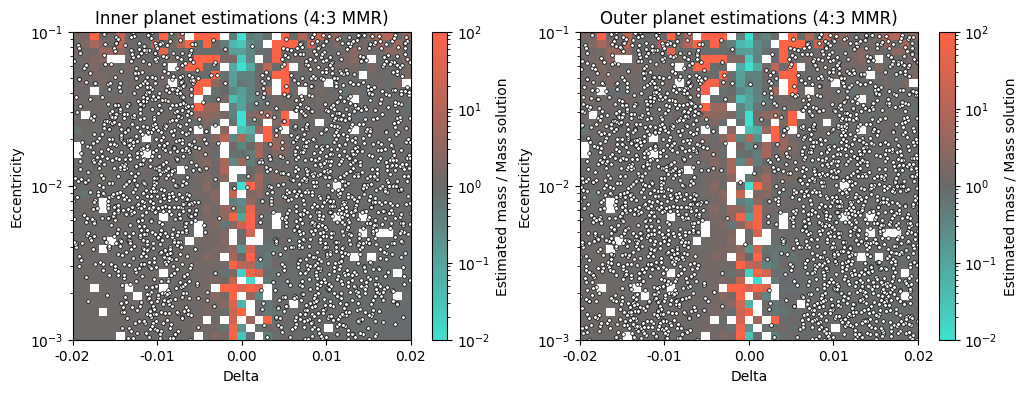

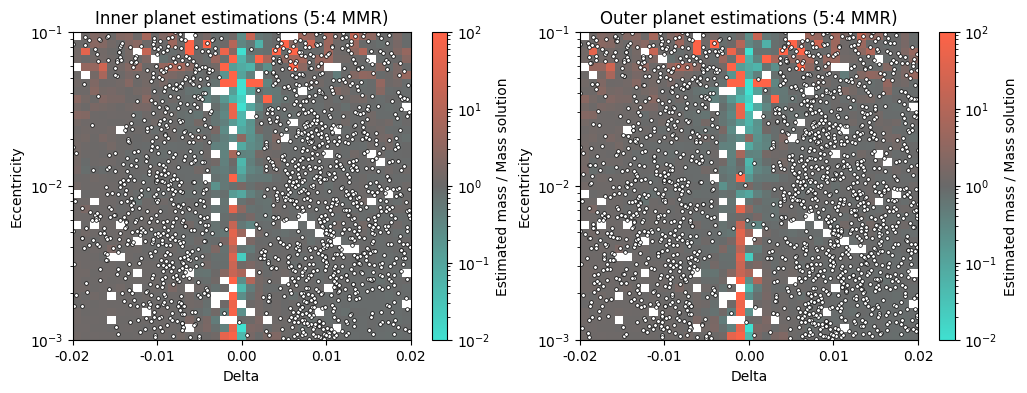

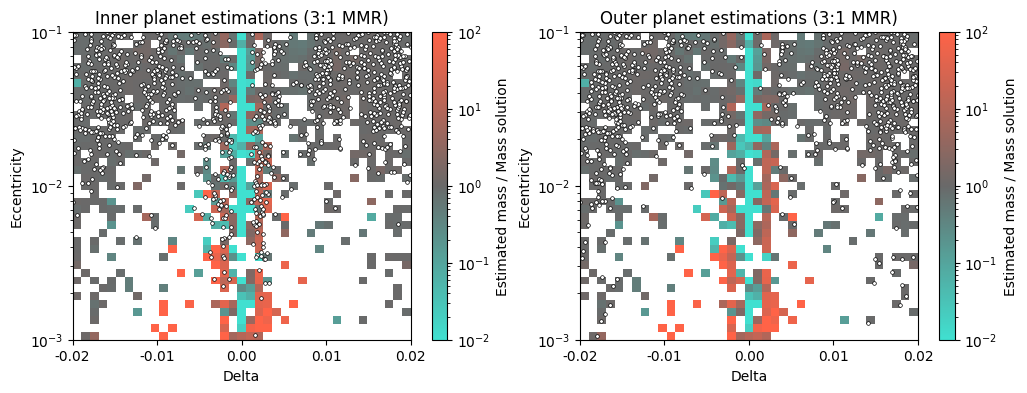

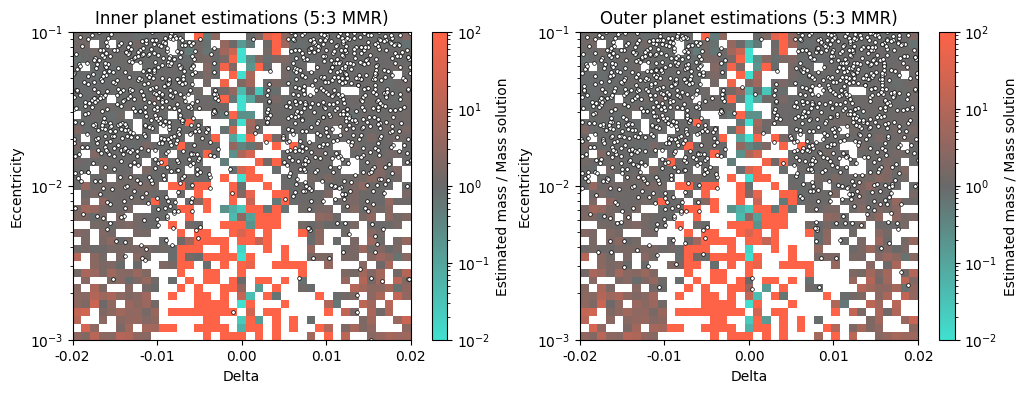

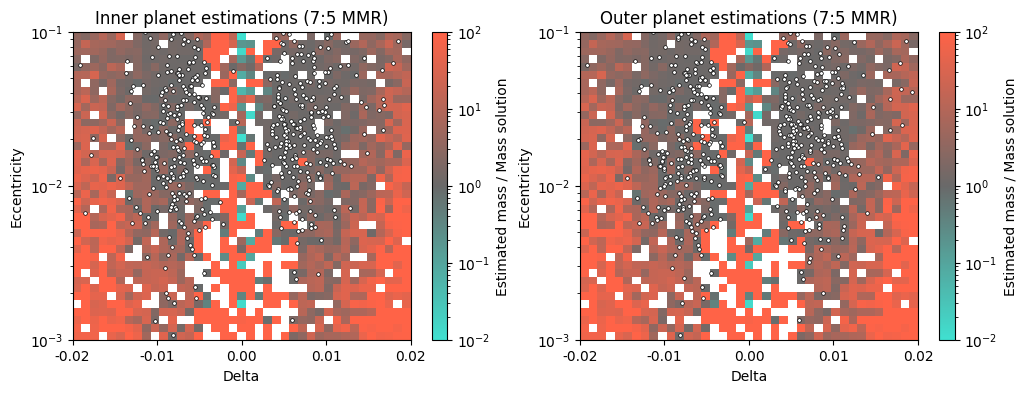

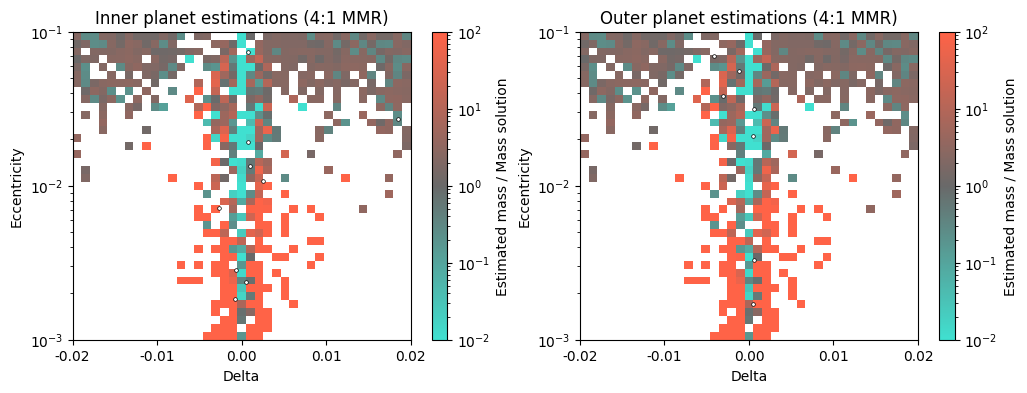

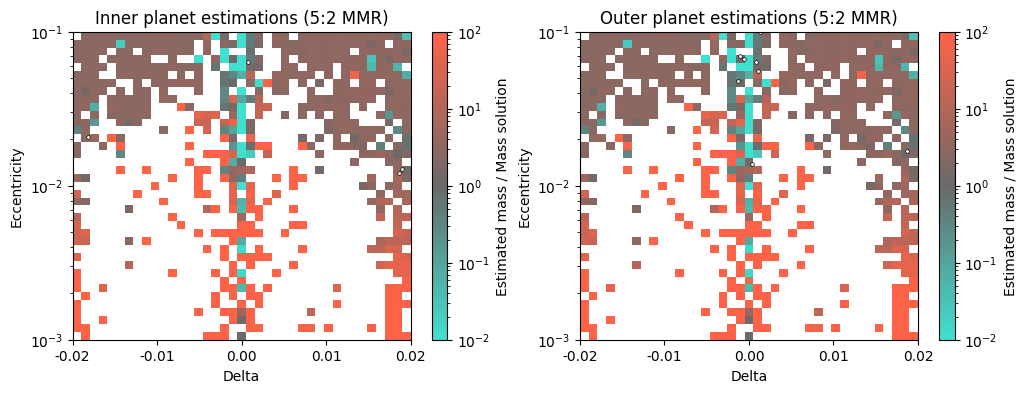

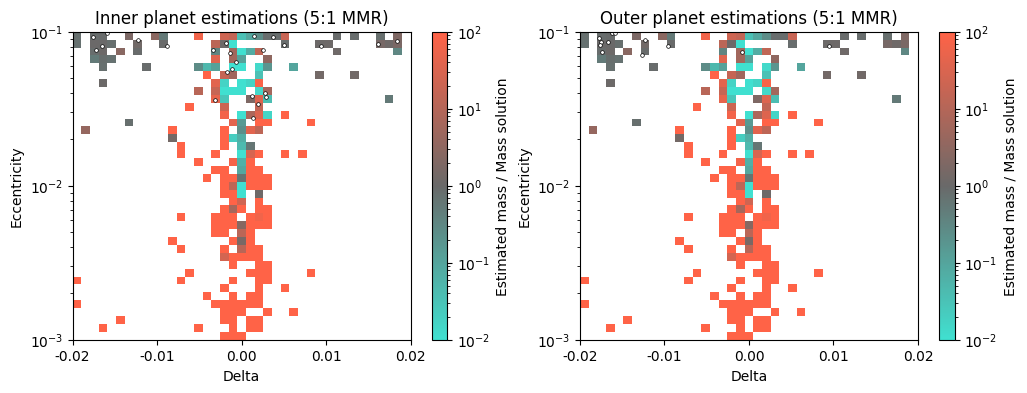

In [9]:
# Recreate figure 2
def PlotValidity(mmr):
    compare_at_mmr = compare[(compare.mmr == mmr) & (compare.valid == True)]
    
    Delta = compare_at_mmr['Delta']
    e1 = compare_at_mmr['e1']; e2 = compare_at_mmr['e2']
    err1 = compare_at_mmr['mu_calc_in'] / compare_at_mmr['mu1']
    err2 = compare_at_mmr['mu_calc_out'] / compare_at_mmr['mu2']
    
    errtol = 1.1
    err1_10p = (err1 <= errtol) & (err1 >= 1/errtol)
    err2_10p = (err2 <= errtol) & (err2 >= 1/errtol)
    
    # Set up grid image
    xbins = np.linspace(-0.02, 0.02, 40)
    ybins = 10**np.linspace(-3, -1, 40)
    # Digitize points into bins (i.e. map Delta = 0 to bin 50/100)
    xi = np.digitize(Delta, xbins) - 1
    yi = np.digitize(e1, ybins) - 1
    Z1 = Z2 = np.full((len(ybins)-1, len(xbins)-1), np.nan) # Initialize array for medians
    
    # Compute median in each bin
    for i in range(len(xbins)-1):
        for j in range(len(ybins)-1):
            mask = (xi == i) & (yi == j)
            err1values = err1[mask]
            err2values = err2[mask]
            Z1[j,i] = np.nanmedian(err1[mask]) if np.any(~np.isnan(err1values)) else np.nan
            Z2[j,i] = np.nanmedian(err2[mask]) if np.any(~np.isnan(err2values)) else np.nan
    
    # Plot
    fig, ax =  plt.subplots(1, 2, figsize=(12,4))
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['turquoise', 'dimgray', 'tomato'])
    norm = mcolors.LogNorm(1e-2, 1e+2)
    
    im0 = ax[0].pcolormesh(xbins, ybins, Z1, norm=norm, cmap=cmap, shading='auto')
    sc0 = ax[0].scatter(Delta[err1_10p], e1[err1_10p], s=7, facecolor='white', edgecolor='black', linewidth=0.5, marker='o')
    plt.colorbar(im0, ax=ax[0], label='Estimated mass / Mass solution')
    ax[0].set_title(f'Inner planet estimations ({mmr} MMR)')
    
    im1 = ax[1].pcolormesh(xbins, ybins, Z2, norm=norm, cmap=cmap, shading='auto')
    sc1 = ax[1].scatter(Delta[err2_10p], e1[err2_10p], s=7, facecolor='white', edgecolor='black', linewidth=0.5, marker='o')
    plt.colorbar(im1, ax=ax[1], label='Estimated mass / Mass solution')
    ax[1].set_title(f'Outer planet estimations ({mmr} MMR)')
    
    for i, a in enumerate(ax):
        a.set_yscale('log')
        a.set_xlabel('Delta'); a.set_ylabel('Eccentricity')
        a.set_xlim(-0.02, 0.02); a.set_ylim(1e-3, 1e-1)
        a.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        a.xaxis.set_major_locator(MultipleLocator(0.01))
    
    plt.show()

mmrlist = ['2:1', '3:2', '4:3', '5:4', '3:1', '5:3', '7:5', '4:1', '5:2', '5:1']
for mmr in mmrlist:
    PlotValidity(mmr)

In [7]:
# Export results
compare.to_csv("allorder_TTVFast_outputs.csv", index=False)